In [7]:
import pandas as pd
import numpy as np

data = pd.read_csv('NY_AirBnB_Feature_2.csv')



cleaned_colnames = [col.strip().replace(" ", "") for col in data.columns]
data.columns = cleaned_colnames
data.columns

# Detecting outliers using the IQR method for the 'price' variable
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
data_no_outliers = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]

# Summary of the dataset with outliers removed
summary_no_outliers = {
    'Initial data size': data.shape,
    'New data size': data_no_outliers.shape,
    'Number of outliers removed': data.shape[0] - data_no_outliers.shape[0]
}

summary_no_outliers

{'Initial data size': (48895, 22),
 'New data size': (45923, 22),
 'Number of outliers removed': 2972}

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Handling missing values: Filling with zeros for review-related features
data_no_outliers['reviews_per_month'].fillna(0, inplace=True)
data_no_outliers['review_frequency'].fillna(0, inplace=True)
data_no_outliers['days_since_last_review'].fillna(0, inplace=True)
data_no_outliers['review_to_availability_ratio'].fillna(0, inplace=True)

# Dropping unnecessary identifier columns
cols_to_drop = ['id', 'name', 'host_id', 'host_name', 'last_review']
data_cleaned = data_no_outliers.drop(columns=cols_to_drop)

# Encoding categorical variables using One-Hot Encoding
categorical_cols = ['neighbourhood_group', 'neighbourhood', 'room_type']
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Applying OneHotEncoder
data_encoded = pd.DataFrame(one_hot_encoder.fit_transform(data_cleaned[categorical_cols]))

# OneHotEncoder removes index; put it back
data_encoded.index = data_cleaned.index

# Remove categorical columns (will replace with one-hot encoding)
num_data = data_cleaned.drop(columns=categorical_cols)

# Add one-hot encoded columns to numerical features
data_prepared = pd.concat([num_data, data_encoded], axis=1)

# Now we have a dataset prepared with encoded categorical variables and missing values handled
# The final step would be to scale the numerical values if the model requires it

# Let's display the first few rows of the prepared dataset
data_prepared.head()

C:\Users\boetr\AppData\Local\Temp\ipykernel_27740\1834286415.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_outliers['reviews_per_month'].fillna(0, inplace=True)
C:\Users\boetr\AppData\Local\Temp\ipykernel_27740\1834286415.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_outliers['review_frequency'].fillna(0, inplace=True)
C:\Users\boetr\AppData\Local\Temp\ipykernel_27740\1834286415.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

,Unnamed:0,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_frequency,...,217,218,219,220,221,222,223,224,225,226
0,0,40.64749,-73.97237,149,1,9,0.21,6,365,0.024658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,40.75362,-73.98377,225,1,45,0.38,2,355,0.126761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,40.80902,-73.94190,150,3,0,0.00,1,365,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,40.68514,-73.95976,89,1,270,4.64,1,194,1.391753,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,40.79851,-73.94399,80,10,9,0.10,1,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [10]:
categories = one_hot_encoder.get_feature_names_out(input_features=categorical_cols)
data_encoded.columns = categories

# Combine the numerical and encoded categorical columns
data_prepared = pd.concat([num_data, data_encoded], axis=1)

# Now let's proceed with scaling the numerical features
# Define numerical columns to scale (excluding the price since it's the target variable)
numerical_cols = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
                  'reviews_per_month', 'calculated_host_listings_count', 
                  'availability_365', 'review_frequency', 
                  'days_since_last_review', 'distance_to_nearest_subway']

# Initialize a scaler
scaler = StandardScaler()

# Scale the numerical columns
data_prepared[numerical_cols] = scaler.fit_transform(data_prepared[numerical_cols])

# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

# Define the target variable (dependent variable) as y
y = data_prepared['price']
X = data_prepared.drop('price', axis=1)

# Split the data - 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Let's display the first few rows of the scaled and prepared dataset
data_prepared.head()

,Unnamed:0,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_frequency,...,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,-1.463898,-0.465607,149,-0.299033,-0.329753,-0.556689,-0.02063,1.962122,-0.121603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0.454210,-0.710925,225,-0.299033,0.464691,-0.451272,-0.14963,1.885363,-0.102699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,1.455464,0.190082,150,-0.198315,-0.528364,-0.686911,-0.18188,1.962122,-0.126168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,-0.783442,-0.194250,89,-0.299033,5.429964,2.190361,-0.18188,0.649544,0.131512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,1.265515,0.145107,80,0.154194,-0.329753,-0.624900,-0.18188,-0.839579,-0.126168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Load your dataset
# df = pd.read_csv('path_to_your_data.csv')

# Preprocess your dataset as required
# ...

# Separate the features and the target variable
y = data_prepared['price']
X = data_prepared.drop('price', axis=1)

# Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of models to evaluate
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor()
}

# Dictionary to hold cross-validation results
cv_results = {}

# Perform cross-validation and store results
for model_name, model in models.items():
    pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                               ('model', model)])
    scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    cv_results[model_name] = rmse_scores.mean()

# Displaying the mean RMSE for each model
for model_name, rmse in cv_results.items():
    print(f"{model_name}: Average RMSE = {rmse:.2f}")

LinearRegression: Average RMSE = 21588379748677.76
Ridge: Average RMSE = 46.87
Lasso: Average RMSE = 47.53
DecisionTree: Average RMSE = 62.10
RandomForest: Average RMSE = 44.37
GradientBoosting: Average RMSE = 44.97


In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define a smaller parameter grid
param_grid = {
    'n_estimators': [100, 200],  # Reduced number of options
    'max_depth': [10, 20],  # Reduced number of options
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using fewer iterations and cross-validation folds
# The verbose=10 setting will print out the progress every time 10% of the n_iter*cv iterations are completed
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                               n_iter=10, cv=3, verbose=10, random_state=42, n_jobs=-1)

# Fit the random search model on a subset of data for quicker results
# Using a subset of 10% of the training data to speed up the search
subset_index = np.random.choice(X_train.index, size=int(0.1 * len(X_train)), replace=False)
X_train_subset = X_train.loc[subset_index]
y_train_subset = y_train.loc[subset_index]

rf_random.fit(X_train_subset, y_train_subset)

# Get the best parameters
best_params = rf_random.best_params_
print(f"Best parameters: {best_params}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}


Mean Squared Error: 1962.94
Root Mean Squared Error: 44.31
R^2 Score: 0.58


C:\Users\boetr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\boetr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\boetr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

<Figure size 1200x600 with 0 Axes>

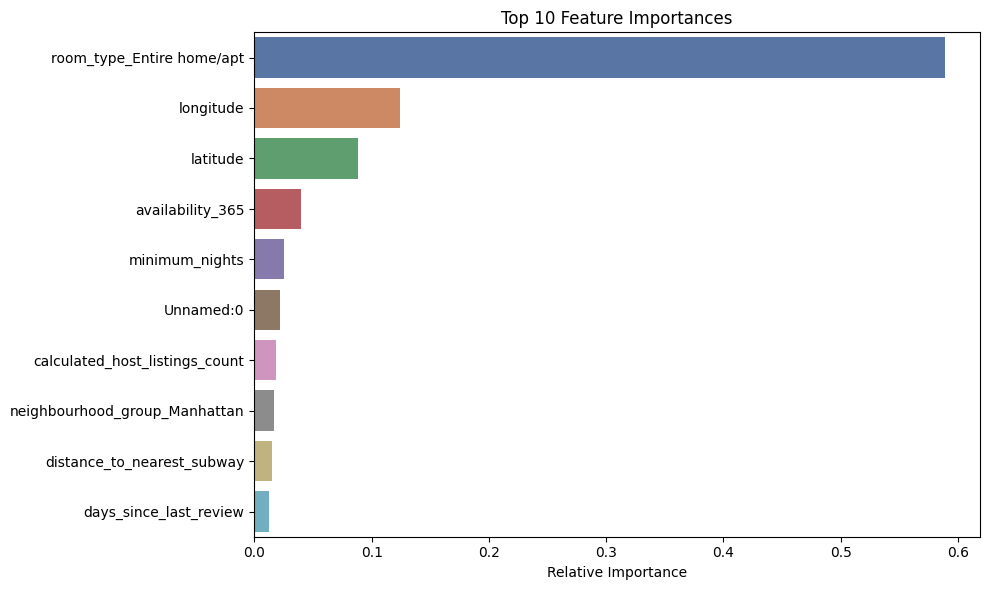

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a test set ready: X_test, y_test

# Train the final model using the best hyperparameters
final_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42
)

final_model.fit(X_train, y_train)

# Predict on the test set
y_pred = final_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print performance metrics
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Feature Importances (if needed)
feature_importances = final_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Visualizations for presentation
plt.figure(figsize=(12, 6))

# Plot feature importances
sorted_indices = indices[:10]
sorted_importances = feature_importances[sorted_indices]
sorted_features = X_train.columns[sorted_indices]

# Create a bar plot for the top 10 most important features using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(y=sorted_features, x=sorted_importances, palette='deep')
plt.title('Top 10 Feature Importances')
plt.xlabel('Relative Importance')

# Show the plot
plt.tight_layout()
plt.show()

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Create the base model to tune
gb = GradientBoostingRegressor(random_state=42)

# Random search of parameters
gb_random = RandomizedSearchCV(estimator=gb, param_distributions=param_grid_gb,
                               n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
gb_random.fit(X_train, y_train)

# Get the best parameters
best_params_gb = gb_random.best_params_
print(f"Best parameters for Gradient Boosting: {best_params_gb}")

# Train the final Gradient Boosting model using the best parameters
final_gb_model = GradientBoostingRegressor(
    n_estimators=best_params_gb['n_estimators'],
    max_depth=best_params_gb['max_depth'],
    min_samples_split=best_params_gb['min_samples_split'],
    min_samples_leaf=best_params_gb['min_samples_leaf'],
    learning_rate=best_params_gb['learning_rate'],
    random_state=42
)

final_gb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = final_gb_model.predict(X_test)

# Calculate performance metrics
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# Print performance metrics for Gradient Boosting
print(f"Mean Squared Error for Gradient Boosting: {mse_gb:.2f}")
print(f"Root Mean Squared Error for Gradient Boosting: {rmse_gb:.2f}")
print(f"R^2 Score for Gradient Boosting: {r2_gb:.2f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for Gradient Boosting: {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 7, 'learning_rate': 0.1}
Mean Squared Error for Gradient Boosting: 1922.92
Root Mean Squared Error for Gradient Boosting: 43.85
R^2 Score for Gradient Boosting: 0.59
